In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.path.append("..")
#import os
from utils.model3 import Net_mask
#from utils.data import Data
#from utils.loss_experiment import Loss
#from scripts.parameters import get_parameters
import torch
#import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [21]:
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m  = torch.mm(torch.t(tensor_D), tensor_D)
n_param = tensor_D.size(dim=0)
tau2 = 1000 # 1/tau2 is the noise added to the diagonal
tensor_Q_m_modified = tensor_Q_m + torch.eye(n_param)*(1./tau2)
sigma2_eps = 0.01  # 1/sigma2_eps is the factor before the likelihood
tensor_mu_m = torch.zeros(n_param)

tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)
tensor_Sigma_eps = torch.eye(n_param)*sigma2_eps
tensor_mu_eps = tensor_mu_m 

In [22]:
def loss(tensor_input, tensor_output):
    tensor_Psi = tensor_output
    tensor_Gd = tensor_input[:,:n_param]
    tensor_mask = tensor_input[:,n_param:]
    tensor_GPsi = tensor_Psi*tensor_mask

    # data residual loss
    tensor_squared_error = torch.square(tensor_GPsi - tensor_Gd)
    tensor_squared_error_sum = torch.sum(tensor_squared_error, [0, 1])
    tensor_data_fit_loss = tensor_squared_error_sum

    # data regularization loss
    tensor_PsiQ_m = torch.matmul(tensor_Psi, tensor_Q_m)
    tensor_PsiQ_m = torch.unsqueeze(tensor_PsiQ_m, 1)
    tensor_Psi = torch.unsqueeze(tensor_Psi, 2)
    tensor_PsiQ_mPsi = torch.bmm(tensor_PsiQ_m, tensor_Psi).squeeze(2)
    tensor_data_regularization_loss = torch.sum(tensor_PsiQ_mPsi)

In [23]:
n_data = 1000
n_points = 6
all_test_obses = torch.zeros(n_points, n_data, 2*n_param)
all_test_obses
all_test_obses[0,:,:].shape

torch.Size([1000, 20])

In [24]:
for i in range(n_points):
    data_cov = 1
    data_mean = torch.zeros(n_param)
    data_covariance = torch.eye(n_param)*data_cov

    torch.manual_seed(10+i)
    tensor_data = torch.zeros(n_data, 2*n_param)
    tensor_d_sample =  MultivariateNormal(loc=data_mean, covariance_matrix=data_covariance).sample(sample_shape=(n_data,))
    #tensor_n_masked = torch.randint(n_param, (n_data,))
    tensor_n_masked = torch.Tensor([i+1])
    tensor_masks = torch.rand(n_data, n_param).argsort(dim=1)
    tensor_masks = (tensor_masks < tensor_n_masked.unsqueeze(1))*1
    tensor_data[:,:n_param] = tensor_d_sample*tensor_masks
    tensor_data[:,n_param:] = tensor_masks
    all_test_obses[i,:,:] = tensor_data
torch.save(all_test_obses, f'../data/test_observations/test_set_full/all_test_obses.pt')

In [25]:
all_test_obses[5,15]

tensor([ 1.2201, -0.7041,  0.9211,  1.4728,  0.3490, -0.8531, -0.0000,  0.0000,
         0.0000, -0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

In [26]:
n_data = 1000
n_points = 6
all_test_solutions = torch.zeros(n_points, n_data, n_param)

for j in range(6):
    for i in range(1000):
        #print(j, i)
        input_tensor = all_test_obses[j,i,:]
        d = input_tensor[:n_param]
        mask = input_tensor[n_param:]
        location = torch.where(mask > 0.5)
        d = d[location]
        n_data = len(d)
        G = torch.zeros(n_data, n_param)
        for idx, elem in enumerate(location[0]):
            G[idx, elem] = 1
        Sigma_eps = torch.matmul(G, torch.matmul(tensor_Sigma_eps, torch.t(G)))
        mu_eps = torch.matmul(G, tensor_mu_eps)

        #matrix calculations
        Sigma_mm = tensor_Sigma_m
        Sigma_dm = torch.matmul(G,Sigma_mm)
        Sigma_md = torch.matmul(Sigma_mm, torch.t(G))
        Sigma_dd = torch.matmul(G, torch.matmul(Sigma_mm, torch.t(G))) + Sigma_eps
        Sigma_dd_inv = torch.inverse(Sigma_dd)
        mu_m_d = tensor_mu_m + torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv),(d-mu_eps))
        Sigma_m_d = Sigma_mm - torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv), Sigma_dm)
        all_test_solutions[j,i,:] = mu_m_d
        print(j, i)
torch.save(all_test_solutions, f'../data/test_observations/test_set_full/all_test_solutions.pt')

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


In [27]:
all_test_solutions[5,:10]

tensor([[ 0.4631,  0.1467, -0.2981, -0.7432, -0.1041,  0.5349,  1.1745, -0.3855,
         -0.0098,  0.7799],
        [-1.5965,  0.6146,  0.2800, -0.0542, -0.4194, -0.0125,  0.3945,  0.8018,
         -1.9066, -1.7506],
        [-1.6592,  0.5748,  1.1074, -0.8930, -0.6479, -0.4032, -0.1591,  0.0850,
         -1.4206, -1.5391],
        [-0.7937,  0.7584, -0.2531, -1.2649, -2.2780, -1.9704, -1.6649, -1.3611,
          0.1736, -0.4445],
        [-1.3024, -1.5063, -1.1389, -0.7728, -0.4073,  0.1641,  0.7357, -0.0707,
          0.0174,  0.1055],
        [-1.3002, -0.9122, -0.1886,  0.2015,  0.5918,  0.9827,  1.1361, -0.3324,
         -2.0809, -1.6898],
        [-0.2867, -0.8008, -0.8985, -0.9971, -1.0017, -0.4596,  0.0820, -1.0469,
         -0.4097,  0.2271],
        [-0.1615, -0.1274, -0.0934,  0.3403,  0.7743,  0.2394, -0.3694, -0.2459,
         -0.1226, -0.1957],
        [-0.9890, -0.0696,  0.8497,  0.3383, -0.1729, -0.6841,  0.3248,  2.7762,
         -0.1614, -3.0992],
        [-0.9188, -

In [28]:
all_test_solutions[1,2,:]

tensor([-0.7878, -0.4423, -0.0973,  0.2477,  0.5928,  0.9386,  1.2853,  1.6332,
         1.9829, -1.1340])

In [29]:
all_test_solutions[1,:6,:]

tensor([[-0.8834, -1.0027, -1.1230, -1.2444, -1.3671, -1.4912, -1.0102, -0.5303,
         -0.6473, -0.7649],
        [-1.1808, -0.7898, -0.3996, -0.0098,  0.3800,  0.7701,  1.1611,  1.5531,
         -0.0099, -1.5729],
        [-0.7878, -0.4423, -0.0973,  0.2477,  0.5928,  0.9386,  1.2853,  1.6332,
          1.9829, -1.1340],
        [-0.2331, -0.1137,  0.0057,  0.1250,  0.2444,  0.3641,  0.4842, -0.5933,
         -0.4728, -0.3528],
        [-0.7302, -0.7435, -0.7302, -0.7176, -0.7057, -0.6945, -0.6840, -0.6945,
         -0.7057, -0.7176],
        [-0.4307, -0.1408,  0.1488,  0.4387,  0.7290,  1.0200,  1.3120,  0.1500,
         -1.0120, -0.7210]])

tensor([-1.6023,  0.0000,  0.0000, -0.2239, -0.0000,  0.5019, -0.3838,  1.6924,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         1.0000,  1.0000,  0.0000,  0.0000])
tensor([-1.6023,  0.0000,  0.0000, -0.2239, -0.0000,  0.5019, -0.3838,  1.6924,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         1.0000,  1.0000,  0.0000,  0.0000])
tensor([1., 0., 0., 1., 0., 1., 1., 1., 0., 0.])
(tensor([0, 3, 5, 6, 7]),)


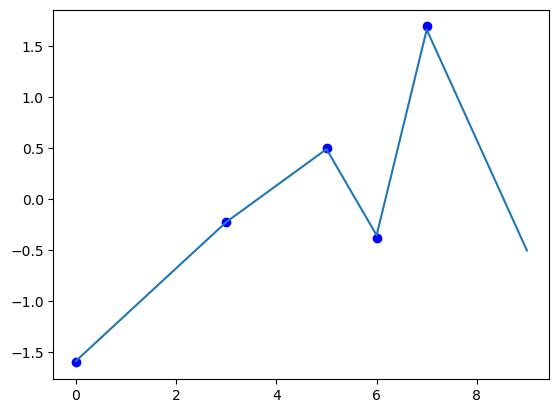

In [35]:
n_points = 4
ind = 50
data = all_test_obses[n_points,ind,:]
print(data)
input_tensor = data 
print(input_tensor)
mask = input_tensor[10:]
print(mask)
location_raw = torch.where(mask > 0.5)
print(location_raw)
location = location_raw[0]
#print(location)
points = input_tensor[location_raw]
#print(points)

#print(all_test_solutions)

plt.plot(location, points, 'bo')
plt.plot(range(10), all_test_solutions[n_points,ind,:])

tensor([-1.6023,  0.0000,  0.0000, -0.2239, -0.0000,  0.5019, -0.3838,  1.6924,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         1.0000,  1.0000,  0.0000,  0.0000])
tensor([-1.6023,  0.0000,  0.0000, -0.2239, -0.0000,  0.5019, -0.3838,  1.6924,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         1.0000,  1.0000,  0.0000,  0.0000])
mask:  tensor([1., 0., 0., 1., 0., 1., 1., 1., 0., 0.])
(tensor([0, 3, 5, 6, 7]),)
tensor([0, 3, 5, 6, 7])
tensor([-1.6023, -0.2239,  0.5019, -0.3838,  1.6924])
tensor([[[-8.2006e-01, -8.2292e-01, -8.2661e-01,  ..., -8.1638e-01,
          -8.1679e-01, -8.1802e-01],
         [ 9.9189e-01,  9.8942e-01,  9.8794e-01,  ...,  9.9536e-01,
           9.9981e-01,  9.9536e-01],
         [ 1.0762e+00,  1.0714e+00,  1.0677e+00,  ...,  1.0650e+00,
           1.0677e+00,  1.0714e+00],
         ...,
         [-7.4249e-01, -7.4064e-01, -7.3953e-01,  ..., -7.4508e-01,
          -7.4841e-01, -7.4508e-

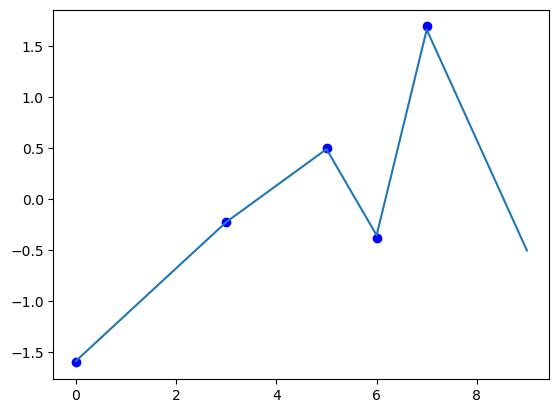

In [38]:
n_points = 4
ind = 50
data = torch.load(f'../data/test_observations/test_set_full/all_test_obses.pt')[n_points,ind,:]
all_test_solutions_ = torch.load(f'../data/test_observations/test_set_full/all_test_solutions.pt')
print(data)
input_tensor = data 
print(input_tensor)
mask = input_tensor[10:]
print('mask: ', mask)
location_raw = torch.where(mask > 0.5)
print(location_raw)
location = location_raw[0]
print(location)
points = input_tensor[location_raw]
print(points)

print(all_test_solutions)

plt.plot(location, points, 'bo')
plt.plot(range(10), all_test_solutions_[n_points,ind,:])

In [32]:
n = 5
for j in range(n):
    if j < 3:
        print(j)

0
1
2


In [33]:
j

4